# Exploratory analysis of updraft-downdraft coupling

Thomas Schanzer  
January 2022

In this notebook we explore approaches to coupling downdrafts to updrafts in our scheme. Specifically, we ask:
> ***How do the characteristics of our model's predicted downdrafts depend on how the downdrafts are coupled to the updrafts?***

After a review of relevant literature, we have formulated the following conclusions and questions:
- Updrafts should trigger downdrafts by the evaporation of precipitation (Windmiller et al., Cotton et al. 2011, Knupp and Cotton 1985)
    - The precipitation can descend from higher levels (Knupp and Cotton 1985)
- Precipitation-driven downdrafts should be initiated at low levels (Torri and Kuang 2016, Cotton et al. 2011, Knupp and Cotton 1985)
    - Torri and Kuang 2016: below ~2.5 km, peak around 1 km
    - Barnes and Garstang 1982 (in Knupp and Cotton 1985): near or below 750 mbar
    - Knupp and Cotton 1985: 2-5 km or 1.5-4.0 km
- Downdrafts could initiate at or below the level of minimum theta-e (Sud and Walker 1993, Zipser 1969 in Cotton et al. 2011)
- Since precipitation-associated downdrafts usually only exist at low levels, we need to consider other initiation mechanisms that generate elevated updrafts (Knupp and Cotton 1985)
    - Elevated downdrafts could be generated by overshooting updrafts (Cotton et al. 2011, Knupp and Cotton 1985)
- Can we model up-down downdrafts, whose air was previously much lower than the initiation level? (Cotton et al. 2011)
- Could averaging an ensemble of downdrafts (and/or updrafts) with a range of deterministically or stochastically chosen parameters give more realistic results, given the wide variation in updraft properties and their high correlation with entrainment history, as found by Romps and Kuang (2010)?
- We should consider a way to have downdraft velocity depend on updraft velocity (Windmiller et al.)
    - How do we achieve this in a physically plausible way, without making artificial and arbitrary adjustments?
    
Torri and Kuang (2016) | Torri and Kuang (2016) | Torri and Kuang (2016) | Sud and Walker (1993)
  -------------  | ------------- | ------------- | -------------
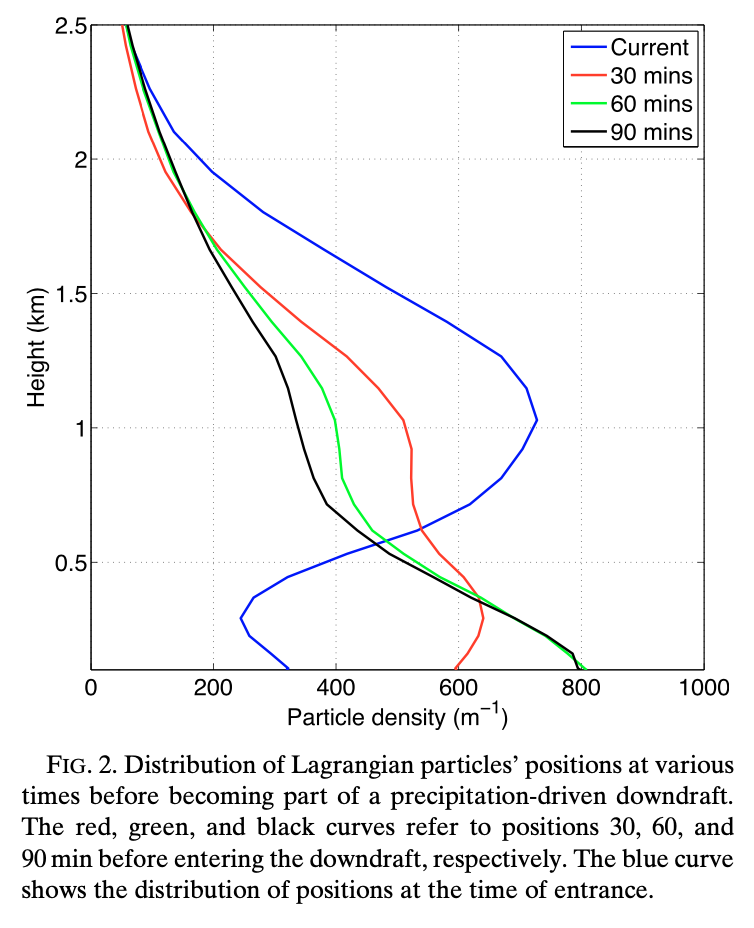 | 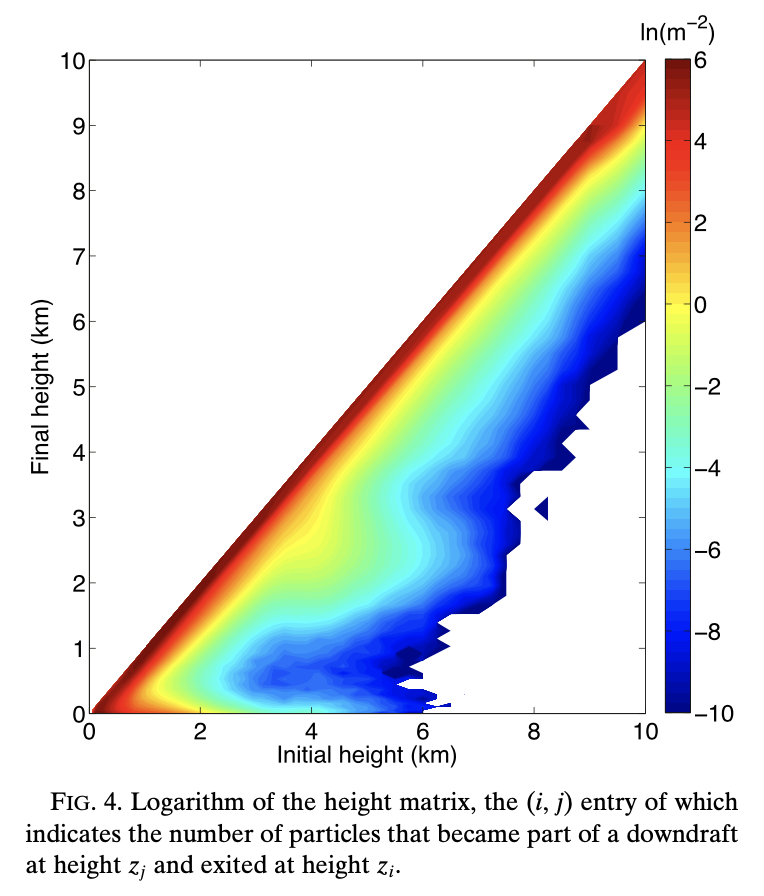 | 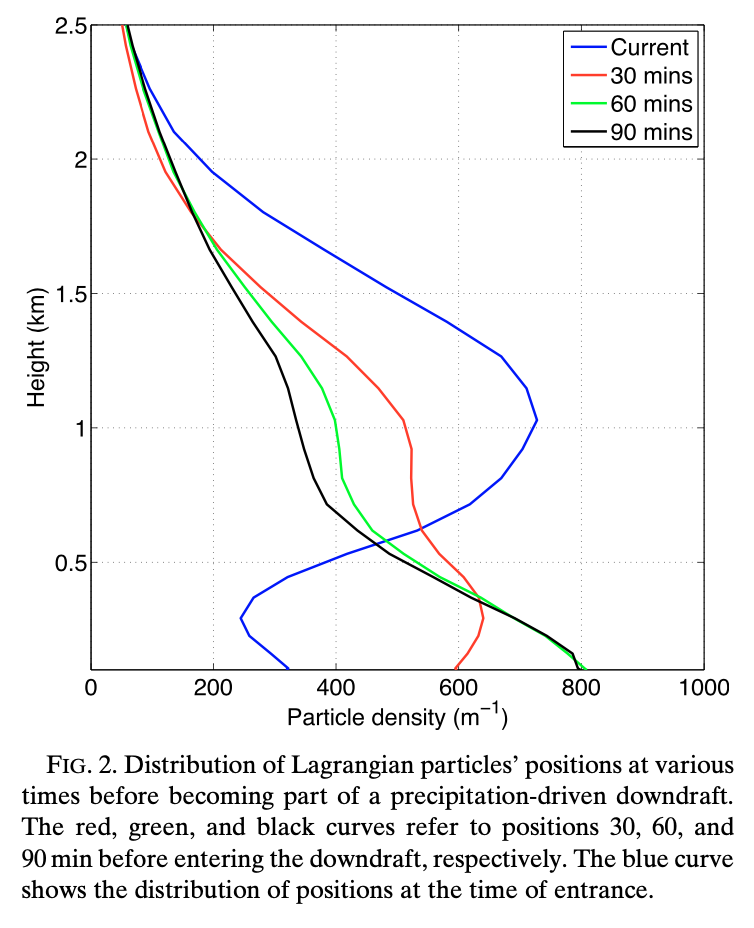 | 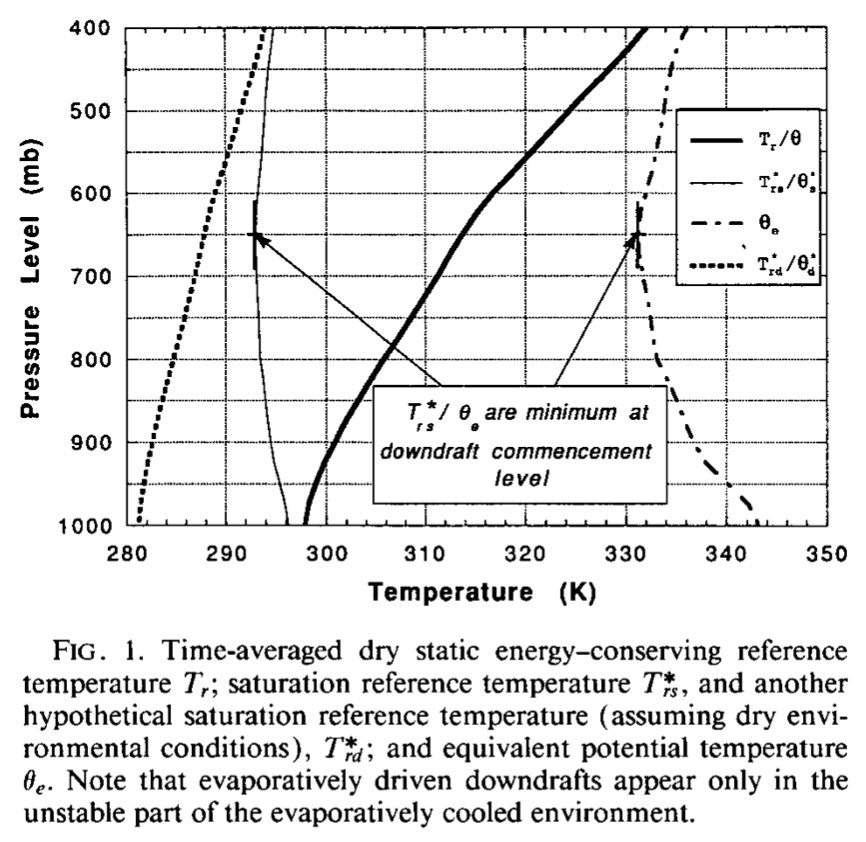

We therefore explore the following possibilities in this notebook:
1. A downdraft initiated by the cumulative precipitation falling out of an updraft within a layer of finite width, with a low initiation level
2. A downdraft initialised with the properties of an overshooting updraft at a high level

In all cases we will vary the parameters that control updraft and downdraft propagation, namely entrainment and detrainment rates, drag and the LWC threshold for precipitation. In light of the findings of Romps and Kuang (2010), we will not pay as much attention to the initial updraft conditions, but rather prescribe typical values.

**References**
- Cotton, W. R., Bryan, G. H., & Van den Heever, S. C. (2011). *Storm and cloud dynamics : the dynamics of clouds and precipitating mesoscale systems* (2nd ed.). Burlington, MA: Academic Press.
- Knupp, K. R., & Cotton, W. R. (1985). Convective cloud downdraft structure: An interpretive survey. *Reviews of Geophysics*, **23**(2), 183–215. https://doi.org/10.1029/RG023i002p00183
- Romps, D. M., & Kuang, Z. (2010). Nature versus nurture in shallow convection. *Journal of the Atmospheric Sciences*, **67**(5), 1655–1666. https://doi.org/10.1175/2009JAS3307.1
- Sud, Y. ., & Walker, G. (1993). A rain evaporation and downdraft parameterization to complement a cumulus updraft scheme and its evaluation using GATE data. *Monthly Weather Review*, **121**(11), 3019–3039. https://doi.org/10.1175/1520-0493(1993)1212.0.CO;2
- Torri, G., & Kuang, Z. (2016). A Lagrangian study of precipitation-driven downdrafts. *Journal of the Atmospheric Sciences*, **73**(2), 839–854. https://doi.org/10.1175/JAS-D-15-0222.1
- Windmiller, J., Bao, J., Sherwood, S. C. & Schanzer, T. D. (in preparation). Downdrafts in a global storm resolving model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
import pandas as pd
from scipy.interpolate import interp1d
import sys
import shelve

import metpy.calc as mpcalc
from metpy.units import units, concatenate

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)
sys.path.append('../convection_scheme')
from thermal_generator import ThermalGenerator, DowndraftResult, equilibrate

In [2]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
generator = ThermalGenerator(pressure, height, temperature, specific_humidity)

## Low-level precipitation-driven downdrafts
### Overview plot
To begin with, we visualise the overall dependence of predicted precipitation-driven downdraft strength on the updraft-downdraft coupling parameters.

We first fix a set of updraft initial conditions (starting at the lowest level, saturated, with a 1 K temperature perturbation). We then choose a set of $(\epsilon, l_\mathrm{crit})$ pairs, and generate for each pair the corresponding updraft properties. We then generate (for each updraft) an ensemble of downdrafts, varying the initial height and the thickness of the layer whose updraft precipitation falls into the downdraft. The downdraft is assumed to have the same entrainment rate as the updraft.

In [3]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit_all = [1e-3, 2e-3, 3e-3]*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
rate_all = [0.1, 0.25, 0.5]*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

rate_all, l_crit_all = np.meshgrid(rate_all, l_crit_all)
rate_all = rate_all.ravel()
l_crit_all = l_crit_all.ravel()

In [4]:
%%time
z_init_down_all = []
z_precip_top_all = []
updrafts_all = []
downdrafts_all = []
total_precip_all = []
for rate, l_crit in zip(rate_all, l_crit_all):
    sys.stdout.write(
        'epsilon = {:.2f}/km, l_crit = {:.1f} g/kg:\n'
        ''.format(rate.m, l_crit.m*1e3))
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        rate, dnu_db, drag, l_crit, basic=True)

    # downdraft parameters:
    # downdraft may initiate anywhere the updraft reaches that is
    # below 4 km and above 500 m
    i_init_down_min = np.min(
        np.argwhere(~np.isnan(updraft.velocity) & (height <= 4000*units.meter))
    )
    i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
    i_init_down = range(i_init_down_min, i_init_down_max+1, 5)
    z_init_down = height[i_init_down_min:i_init_down_max+1:5]
    # the top of the precipitating layer must be somewhere the updraft
    # reaches and where there is nonzero precipitation
    i_precip_top_min = np.min(
        np.argwhere(~np.isnan(updraft.velocity) & (height <= 8000*units.meter))
    )
    i_precip_top_max = np.max(np.argwhere(updraft.precipitation > 0))
    i_precip_top = range(i_precip_top_min, i_precip_top_max+1, 5)
    z_precip_top = height[i_precip_top_min:i_precip_top_max+1:5]

    downdrafts = np.full(
        (len(i_init_down), len(i_precip_top)), np.nan, dtype='object')
    total_precip = np.full((len(i_init_down), len(i_precip_top)), np.nan)
    total_precip *= units.dimensionless

    valid_entries = np.atleast_2d(i_init_down).T >= np.atleast_2d(i_precip_top)
    i_valid = np.argwhere(valid_entries)[:,0]
    j_valid = np.argwhere(valid_entries)[:,1]
    n_calc = np.sum(valid_entries)
    n_done = 0
    for i, j in zip(i_valid, j_valid):
        n_done += 1
        sys.stdout.write(f'\r    Calculation {n_done} of {n_calc}    ')
        # sum the precipitation from the chosen levels, weighted
        # by the fractional mass remaining at each level since
        # the precipitation reported for the updraft is per unit mass
        # remaining, not per unit original mass
        total_precip[i,j] = np.nansum((
            updraft.precipitation*updraft.m_remaining
        )[i_precip_top[j] : i_init_down[i] + 1])
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i,j], w_initial,
            rate, dnu_db, drag, basic=True)

    z_init_down_all.append(z_init_down)
    z_precip_top_all.append(z_precip_top)
    updrafts_all.append(updraft)
    downdrafts_all.append(downdrafts)
    total_precip_all.append(total_precip)
    sys.stdout.write('\n')
sys.stdout.write('\n')

epsilon = 0.10/km, l_crit = 1.0 g/kg:
    Calculation 220 of 220    
epsilon = 0.25/km, l_crit = 1.0 g/kg:
    Calculation 220 of 220    
epsilon = 0.50/km, l_crit = 1.0 g/kg:
    Calculation 208 of 208    
epsilon = 0.10/km, l_crit = 2.0 g/kg:
    Calculation 218 of 218    
epsilon = 0.25/km, l_crit = 2.0 g/kg:
    Calculation 218 of 218    
epsilon = 0.50/km, l_crit = 2.0 g/kg:
    Calculation 192 of 192    
epsilon = 0.10/km, l_crit = 3.0 g/kg:
    Calculation 211 of 211    
epsilon = 0.25/km, l_crit = 3.0 g/kg:
    Calculation 211 of 211    
epsilon = 0.50/km, l_crit = 3.0 g/kg:
    Calculation 185 of 185    

CPU times: user 3min 32s, sys: 1.22 s, total: 3min 33s
Wall time: 3min 33s


1

In [24]:
max_velocity_all = []
max_velocity_height_all = []
min_height_all = []
for downdrafts in downdrafts_all:
    max_velocity = np.full(downdrafts.shape, np.nan)*units.meter/units.second
    max_velocity_height = np.full(downdrafts.shape, np.nan)*units.meter
    min_height = np.full(downdrafts.shape, np.nan)*units.meter
    for i in range(downdrafts.shape[0]):
        for j in range(downdrafts.shape[1]):
            if not isinstance(downdrafts[i,j], DowndraftResult):
                max_velocity[i,j] = np.nan
                max_velocity_height[i,j] = np.nan
                min_height[i,j] = np.nan
            else:
                max_velocity[i,j] = np.nanmin(
                    downdrafts[i,j].velocity.m)*units.meter/units.second
                i_max_velocity = np.nanargmin(downdrafts[i,j].velocity)
                max_velocity_height[i,j] = height[i_max_velocity]
                i_min_height = np.max(
                    np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
                min_height[i,j] = height[i_min_height]
    max_velocity_all.append(max_velocity)
    max_velocity_height_all.append(max_velocity_height)
    min_height_all.append(min_height)
    max_evap_all.append(max_evap)

In [28]:
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

z_max_precip = np.zeros(rate_all.size)*units.meter
for i, updraft in enumerate(updrafts_all):
    precip = updraft.precipitation*updraft.m_remaining
    precip[height > 4000*units.meter] = np.nan
    z_max_precip[i] = height[np.nanargmax(precip)]

In [41]:
with shelve.open('coupling_figures_data/precip_driven_overview_data') as db:
    db['z_precip_top_all'] = z_precip_top_all
    db['z_init_down_all'] = z_init_down_all
    db['updrafts_all'] = updrafts_all
    db['downdrafts_all'] = downdrafts_all
    db['total_precip_all'] = total_precip_all
    print(list(db.keys()))

['updrafts_all', 'z_precip_top_all', 'total_precip_all', 'z_init_down_all', 'downdrafts_all']


In [4]:
with shelve.open('coupling_figures_data/precip_driven_overview_data') as db:
    z_precip_top_all = db['z_precip_top_all']
    z_init_down_all = db['z_init_down_all']
    updrafts_all = db['updrafts_all']
    downdrafts_all = db['downdrafts_all']
    total_precip_all = db['total_precip_all']
    print(list(db.keys()))

['updrafts_all', 'z_precip_top_all', 'total_precip_all', 'z_init_down_all', 'downdrafts_all']


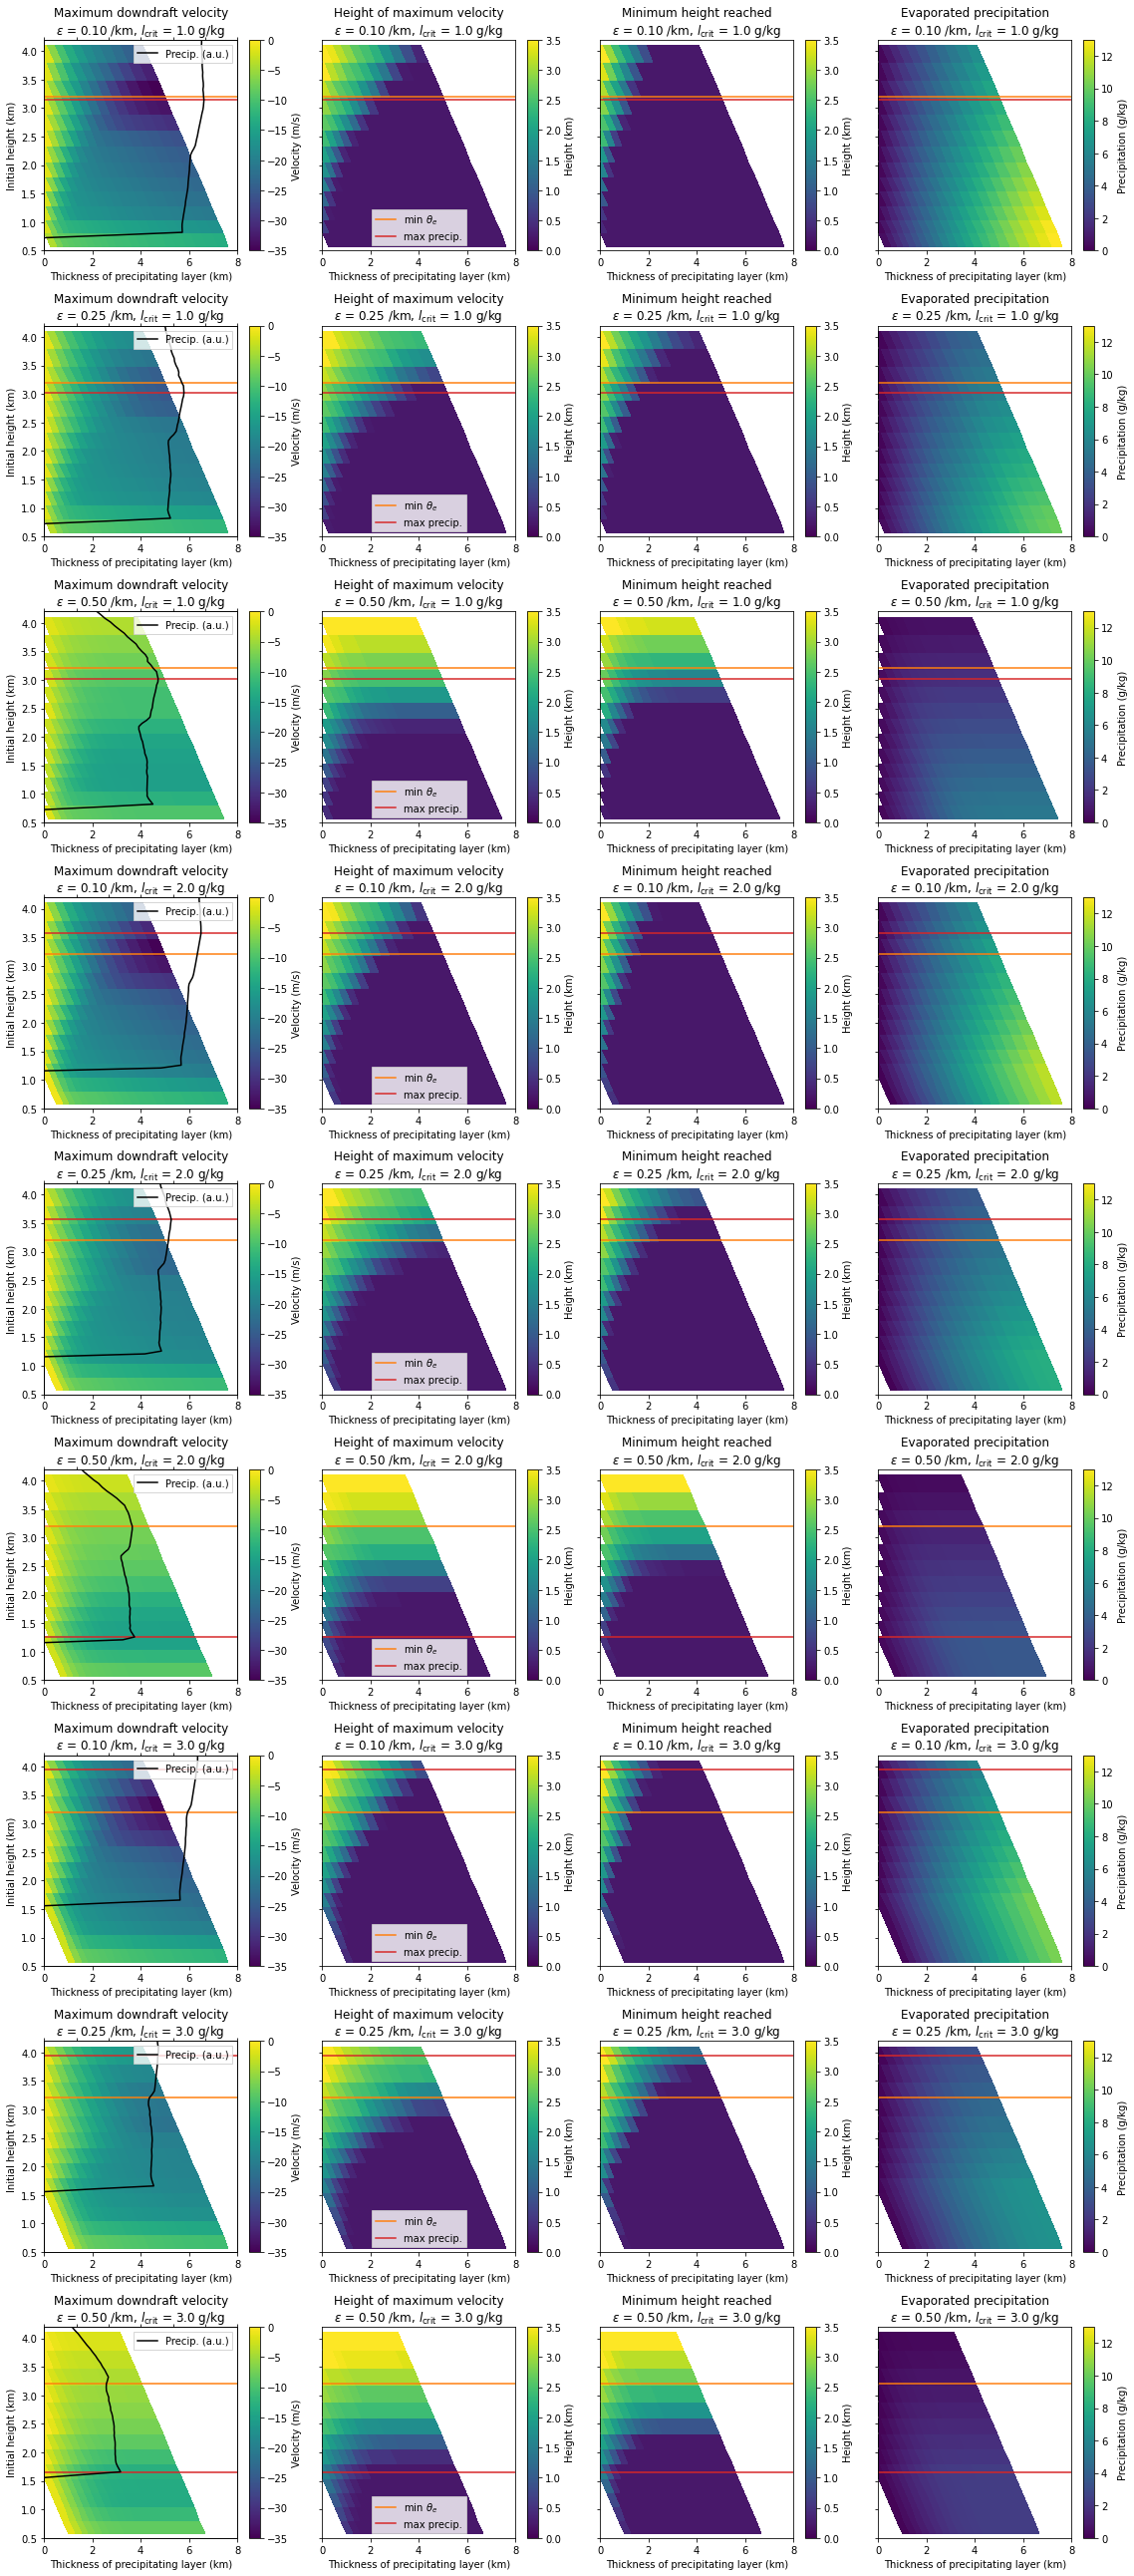

In [33]:
fig, axes = plt.subplots(rate_all.size, 4, figsize=(16,4*rate_all.size))
for i, (rate, l_crit) in enumerate(zip(rate_all, l_crit_all)):
    X, Y = np.meshgrid(z_precip_top_all[i], z_init_down_all[i])
    
    mesh = axes[i,0].pcolormesh(
        (X - Y)*1e-3, Y*1e-3, max_velocity_all[i], shading='nearest')
    mesh.set_clim(-35, 0)
    cbar = fig.colorbar(mesh, ax=axes[i,0])
    cbar.set_label('Velocity (m/s)')
    axes[i,0].set(xlabel='Thickness of precipitating layer (km)',
                ylabel='Initial height (km)',
                title='Maximum downdraft velocity\n'
                      '$\epsilon$ = {:.2f} /km, '
                      '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                      ''.format(rate.m, l_crit.m*1e3))
    axes[i,0].axhline(z_min_theta_e*1e-3, color='tab:orange')
    axes[i,0].axhline(z_max_precip[i]*1e-3, color='tab:red')
    axes[i,0].set_xlim(0, 8)
    axes[i,0].set_ylim(0.5, 4.2)
    ax = axes[i,0].twiny()
    ax.plot(updrafts_all[i].precipitation*updrafts_all[i].m_remaining*1e3,
            height*1e-3, 'k', label='Precip. (a.u.)')
    ax.set_xlim(0, 0.15)
    ax.set(xlabel='')
    ax.set_xticklabels([])
    ax.legend(loc='upper right', fancybox=False)
    
    mesh = axes[i,1].pcolormesh(
        (X - Y)*1e-3, Y*1e-3, max_velocity_height_all[i]*1e-3,
        shading='nearest')
    mesh.set_clim(0, 3.5)
    cbar = fig.colorbar(mesh, ax=axes[i,1])
    cbar.set_label('Height (km)')
    axes[i,1].set(xlabel='Thickness of precipitating layer (km)',
                ylabel='',
                title='Height of maximum velocity\n'
                      '$\epsilon$ = {:.2f} /km, '
                      '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                      ''.format(rate.m, l_crit.m*1e3))
    axes[i,1].set_yticklabels([])
    axes[i,1].axhline(z_min_theta_e*1e-3, color='tab:orange',
                      label=r'min $\theta_e$')
    axes[i,1].axhline(z_max_precip[i]*1e-3, color='tab:red',
                      label='max precip.')
    axes[i,1].set_xlim(0, 8)
    axes[i,1].set_ylim(0.5, 4.2)
    axes[i,1].legend(loc='lower center', fancybox=False)
    
    mesh = axes[i,2].pcolormesh(
        (X - Y)*1e-3, Y*1e-3, min_height_all[i]*1e-3, shading='nearest')
    mesh.set_clim(0, 3.5)
    cbar = fig.colorbar(mesh, ax=axes[i,2])
    cbar.set_label('Height (km)')
    axes[i,2].set(xlabel='Thickness of precipitating layer (km)',
                  ylabel='',
                  title='Minimum height reached\n'
                        '$\epsilon$ = {:.2f} /km, '
                        '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                        ''.format(rate.m, l_crit.m*1e3))
    axes[i,2].set_yticklabels([])
    axes[i,2].axhline(z_min_theta_e*1e-3, color='tab:orange')
    axes[i,2].axhline(z_max_precip[i]*1e-3, color='tab:red')
    axes[i,2].set_xlim(0, 8)
    axes[i,2].set_ylim(0.5, 4.2)
    
    mesh = axes[i,3].pcolormesh(
        (X - Y)*1e-3, Y*1e-3, total_precip_all[i]*1e3, shading='nearest')
    mesh.set_clim(0, 13)
    cbar = fig.colorbar(mesh, ax=axes[i,3])
    cbar.set_label('Precipitation (g/kg)')
    axes[i,3].set(xlabel='Thickness of precipitating layer (km)',
                ylabel='',
                title='Evaporated precipitation\n'
                      '$\epsilon$ = {:.2f} /km, '
                      '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                      ''.format(rate.m, l_crit.m*1e3))
    axes[i,3].set_yticklabels([])
    axes[i,3].axhline(z_min_theta_e*1e-3, color='tab:orange')
    axes[i,3].axhline(z_max_precip[i]*1e-3, color='tab:red')
    axes[i,3].set_xlim(0, 8)
    axes[i,3].set_ylim(0.5, 4.2)
    

fig.tight_layout()
fig.savefig('coupling_figures_data/precip_driven_overview.png', dpi=100,
            facecolor='w', bbox_inches='tight')

**Discussion**:
- At low entrainment rates, maximum downdraft velocity is achieved for initial levels around 3 km.
    - 3 km is near the level of minimum $\theta_e$, and the presence of the maximum despite lower precipitation amounts there may therefore be due to the instability of the sounding.
    - Comparison of the second and third columns of plots suggests that downdrafts with low initiation levels may reach the surface before they are able to attain their maximum possible velocities.
- For higher entrainment rates, the initial level producing the maximum velocity shifts downwards to 1.0 - 1.5 km.
    - This is because lower parts of the sounding have more precipitation available above them, generating larger initial negative buoyancy.
    - The high degree of mixing eliminates the advantage of higher, more unstable initiation levels.
    - The updraft's vertical precipitation profile tends to be roughly uniform in the lowest 4 km for low to moderate entrainment rates, but decreases more sharply with height for high entrainment rates (due to the detrainment of moister parcels from lower levels before they are able to condense all their vapour). This also makes the higher initiation levels less favourable for downdrafts.
    - For higher precipitation thresholds (2 and 3 g/kg), this aligns well with the level of peak precipitation, which is also the lowest precipitating layer.
- For intermediate entrainment rates, the dependence of maximum velocity on initial height is weaker and may have faint peaks at both 3 km and 1.0 - 1.5 km.
    - This may indicate a balance between the aforementioned effects.
    - In these cases, the updraft precipitation profile is also fairly uniform.
- Maximum velocity is more or less independent of the thickness of the precipitation layer once it exceeds about 2 km, except for downdrafts starting around 3 km in the low-entrainment case.
    - For low initiation levels, this may be because the most negatively buoyant downdrafts reach the surface before they are able to attain their maximum possible velocities.
- Increasing the precipitation threshold reduces downdraft strength by reducing the amount of precipitation available, but otherwise does not affect the above conclusions (except that it may change the level of maximum precipitation).

### Detailed analysis

In light of the previous results, we now fix the precipitation threshold at 2 g/kg and the thickness of the precipitating layer at 2 km, and vary the initiation level and entrainment rate in smaller steps.

In [3]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 0.601, 0.01)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [4]:
%%time
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts = np.zeros((z_init_down.size, epsilon.size), dtype='object')
total_precip = np.zeros((z_init_down.size, epsilon.size))*units.dimensionless
n_calc = epsilon.size*z_init_down.size
n_done = 0
for j in range(epsilon.size):
    updrafts[j] = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon[j], dnu_db, drag, l_crit, basic=True)
    
    for i in range(z_init_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        
        total_precip[i,j] = np.nansum((
            updrafts[j].precipitation*updrafts[j].m_remaining
        )[i_precip_top[i] : i_init_down[i] + 1])
        
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i,j], w_initial,
            epsilon[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 1792 of 1792    
CPU times: user 4min 2s, sys: 1.25 s, total: 4min 3s
Wall time: 4min 4s


1

In [5]:
with shelve.open('coupling_figures_data/precip_driven_detail_data') as db:
    db['updrafts'] = updrafts
    db['downdrafts'] = downdrafts
    db['total_precip'] = total_precip
    print(list(db.keys()))

['updrafts', 'total_precip', 'downdrafts']


In [78]:
max_velocity = np.zeros((z_init_down.size, epsilon.size))
max_velocity *= units.meter/units.second
max_velocity_height = np.zeros((z_init_down.size, epsilon.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon.size))*units.meter
max_velocity_up = np.zeros(epsilon.size)*units.meter/units.second
max_precip_height = np.zeros(epsilon.size)*units.meter

for j in range(epsilon.size):
    max_velocity_up[j] = np.nanmax(updrafts[j].velocity)
    i_max_precip = np.nanargmax(
        updrafts[j].precipitation*updrafts[j].m_remaining)
    max_precip_height[j] = height[i_max_precip]
    for i in range(z_init_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
precip_profile = concatenate(
    [[updraft.precipitation] for updraft in updrafts]).T
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
            
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

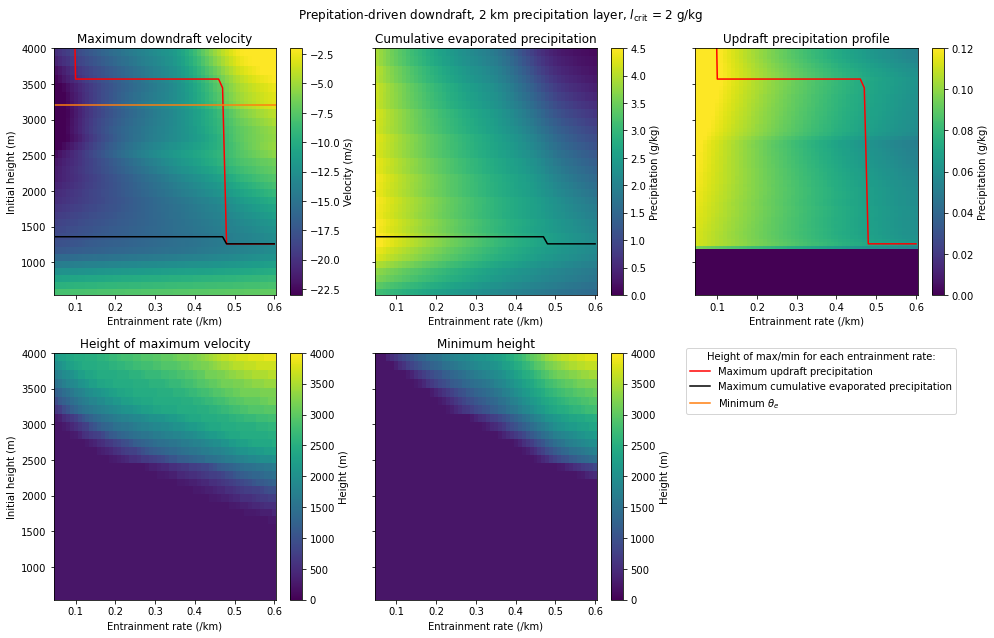

In [112]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-23, -2)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].plot(epsilon, max_precip_height, 'r',
               label='Maximum updraft precipitation')
axes[0,0].plot(epsilon, max_evap_height, 'k',
               label='Maximum cumulative evaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Entrainment rate (/km)', ylabel='Initial height (m)',
       title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].pcolormesh(
    epsilon, z_init_down, total_precip*1e3, shading='nearest')
mesh.set_clim(0, 4.5)
cbar = plt.colorbar(mesh, ax=axes[0,1])
cbar.set_label('Precipitation (g/kg)')
axes[0,1].plot(epsilon, max_evap_height, 'k', label='Max evap.')
axes[0,1].set(xlabel='Entrainment rate (/km)', ylabel='',
       title='Cumulative evaporated precipitation')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].pcolormesh(
    epsilon, height, precip_profile*1e3, shading='nearest')
mesh.set_clim(0, 0.12)
cbar = plt.colorbar(mesh, ax=axes[0,2])
cbar.set_label('Precipitation (g/kg)')
axes[0,2].plot(epsilon, max_precip_height, 'r', label='Max precip.')
axes[0,2].set(xlabel='Entrainment rate (/km)', ylabel='',
       title='Updraft precipitation profile')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 4000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Entrainment rate (/km)', ylabel='Initial height (m)',
       title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 4000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Entrainment rate (/km)', ylabel='',
       title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.69, 0.35),
           title='Height of max/min for each entrainment rate:')

fig.suptitle('Prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg')
fig.tight_layout()
fig.savefig('coupling_figures_data/precip_driven_detail.png',
            dpi=100, facecolor='w', bbox_inches='tight')

**Discussion**
- As before, we see a maximum in downdraft velocity for initiation levels around 3.0 - 3.5 km, and a maximum around 1.0 - 1.5 km for high entrainment rates.
- With the increased entrainment rate resolution of this experiment, we can now see that the higher maximum quickly disappears as entrainment rate increases, while the lower maximum persists, hardly changing in position or magnitude.
- We also see that the lower maximum coincides with the level of maximum cumulative evaporated precipitation, supporting our conclusion that the maximum is due to low levels having more precipitation available above them.

### Conclusions
There are two regions in the sounding that can produce the strongest precipitation-driven, updraft-coupled downdrafts in our model:
- A higher level around 3.0 - 3.5 km that only exists for low entrainment rates, whose position is well approximated by the level of minimum $\theta_e$ in the sounding. We attribute this to the greater available potential energy at these levels.
- A lower level around 1.0 - 1.5 km that persists at all entrainment rates, whose position is well approximated by the level of maximum cumulative precipitation in a 2 km window above the initial level. We attribute this to the greater amount of precipitation available to the low levels.

The positions of these maxima are consistent with the findings of Torri and Kuang (2016) and the work reviewed by Knupp and Cotton (1985): *the strongest precipitation-driven downdrafts initiate at low levels*.

Varying the LWC threshold for precipitation does not seem to affect the existence or positions of the above maxima. Increasing the thickness of the layer above the downdraft from which precipitation is drawn, beyond about 2 km, does not substantially affect the downdraft's strength.

## Elevated downdrafts from overshooting updrafts

In [97]:
def overshooting_pair(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit):
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)
    i_top = np.min(np.argwhere(~np.isnan(updraft.velocity)))
    t_init_down, q_init_down, l_init_down = equilibrate(
        pressure[i_top], updraft.temperature[i_top],
        updraft.specific_humidity[i_top], updraft.liquid_content[i_top])
    downdraft = generator.downdraft(
        i_top, t_init_down, q_init_down, l_init_down, w_initial,
        epsilon, dnu_db, drag, basic=True)
    return updraft, downdraft

In [155]:
# updraft parameters
i_init_up_max = height.size - 1
i_init_up_min = np.argmin(np.abs(height - 1e4*units.meter))
i_init_up = range(i_init_up_min, i_init_up_max+1, 4)
z_init_up = height[i_init_up_min:i_init_up_max+1:4]
t_pert = 1.0*units.delta_degC
q_pert = 0*units.dimensionless
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.02)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [156]:
%%time
updrafts = np.zeros((z_init_up.size, epsilon.size), dtype='object')
downdrafts = np.zeros((z_init_up.size, epsilon.size), dtype='object')
n_calc = z_init_up.size*epsilon.size
n_done = 0
for i in range(z_init_up.size):
    for j in range(epsilon.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        updrafts[i,j], downdrafts[i,j] = overshooting_pair(
            i_init_up[i], t_pert, q_pert, l_initial, w_initial,
            epsilon[j], dnu_db, drag, l_crit)
sys.stdout.write('\n')

Calculation 1728 of 1728    
CPU times: user 12min 11s, sys: 2.02 s, total: 12min 13s
Wall time: 12min 15s


1

In [198]:
with shelve.open('coupling_figures_data/overshooting_data') as db:
    db['updrafts'] = updrafts
    db['downdrafts'] = downdrafts
    print(list(db.keys()))

['downdrafts', 'updrafts']


In [157]:
max_velocity_up = np.zeros((z_init_up.size, epsilon.size))
max_velocity_up *= units.meter/units.second
max_velocity_down = np.zeros((z_init_up.size, epsilon.size))
max_velocity_down *= units.meter/units.second
z_top = np.zeros((z_init_up.size, epsilon.size))*units.meter
z_min_down = np.zeros((z_init_up.size, epsilon.size))*units.meter
for i in range(z_init_up.size):
    for j in range(epsilon.size):
        max_velocity_up[i,j] = np.nanmax(updrafts[i,j].velocity)
        max_velocity_down[i,j] = np.nanmin(downdrafts[i,j].velocity)
        i_top = np.min(np.argwhere(~np.isnan(updrafts[i,j].velocity)))
        z_top[i,j] = height[i_top]
        i_min_down = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        z_min_down[i,j] = height[i_min_down]

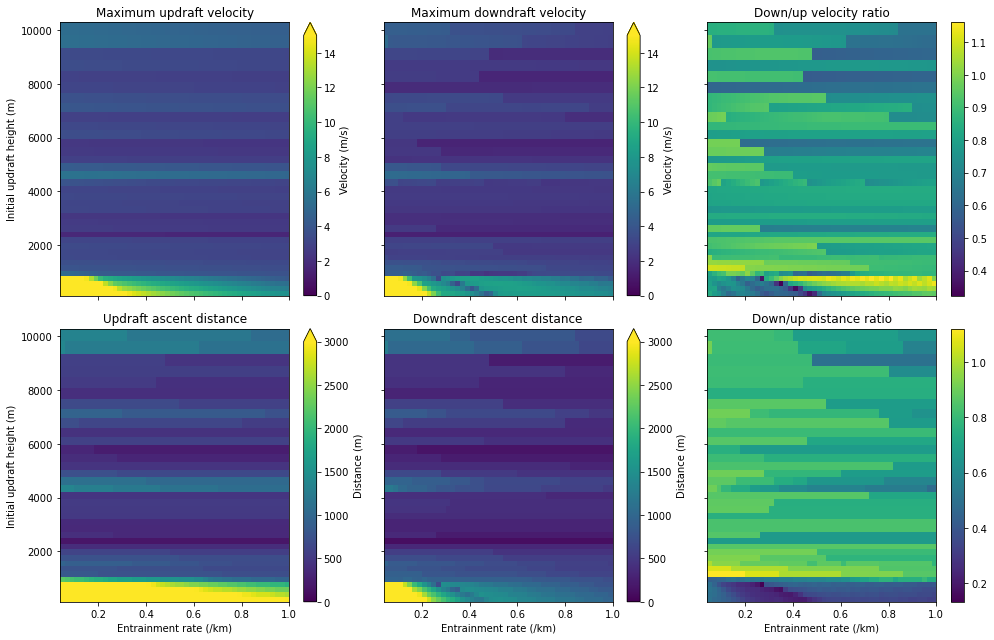

In [197]:
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

mesh = axes[0,0].pcolormesh(
    epsilon, z_init_up, max_velocity_up, shading='nearest')
mesh.set_clim(0, 15)
cbar = plt.colorbar(mesh, ax=axes[0,0], extend='max')
cbar.set_label('Velocity (m/s)')
axes[0,0].set_title('Maximum updraft velocity')

mesh = axes[0,1].pcolormesh(
    epsilon, z_init_up, -max_velocity_down, shading='nearest')
mesh.set_clim(0, 15)
cbar = plt.colorbar(mesh, ax=axes[0,1], extend='max')
cbar.set_label('Velocity (m/s)')
axes[0,1].set_title('Maximum downdraft velocity')

mesh = axes[0,2].pcolormesh(
    epsilon, z_init_up, -max_velocity_down/max_velocity_up, shading='nearest')
cbar = plt.colorbar(mesh, ax=axes[0,2])
axes[0,2].set_title('Down/up velocity ratio')

mesh = axes[1,0].pcolormesh(
    epsilon, z_init_up, z_top - np.atleast_2d(z_init_up).T, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0], extend='max')
cbar.set_label('Distance (m)')
axes[1,0].set_title('Updraft ascent distance')

mesh = axes[1,1].pcolormesh(
    epsilon, z_init_up, z_top - z_min_down, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1], extend='max')
cbar.set_label('Distance (m)')
axes[1,1].set_title('Downdraft descent distance')

mesh = axes[1,2].pcolormesh(
    epsilon, z_init_up,
    (z_top - z_min_down)/(z_top - np.atleast_2d(z_init_up).T),
    shading='nearest')
cbar = plt.colorbar(mesh, ax=axes[1,2])
axes[1,2].set_title('Down/up distance ratio')

for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
for ax in axes[0,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
for ax in axes[:,0].ravel():
    ax.set_ylabel('Initial updraft height (m)')
    
for ax in axes[1,:].ravel():
    ax.set_xlabel('Entrainment rate (/km)')

fig.tight_layout()

In [205]:
(np.mean(-max_velocity_down/max_velocity_up),
 np.std(-max_velocity_down/max_velocity_up))

(0.8185086603949089 <Unit('dimensionless')>,
 0.12139878625415931 <Unit('dimensionless')>)

In [206]:
(np.mean((z_top - z_min_down)/(z_top - np.atleast_2d(z_init_up).T)),
 np.std((z_top - z_min_down)/(z_top - np.atleast_2d(z_init_up).T)))

(0.730266186694697 <Unit('dimensionless')>,
 0.16864806042278685 <Unit('dimensionless')>)

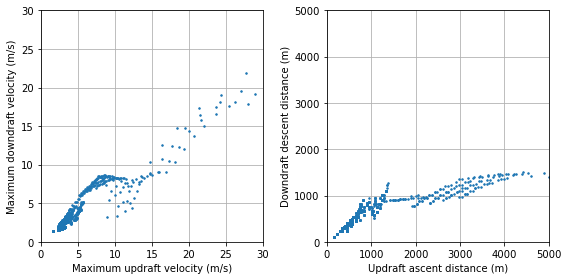

In [201]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].plot(max_velocity_up.ravel(), -max_velocity_down.ravel(), '.', markersize=3)
axes[0].set_xlim(0, 30)
axes[0].set_ylim(0, 30)
axes[0].grid()
axes[0].set(xlabel='Maximum updraft velocity (m/s)',
            ylabel='Maximum downdraft velocity (m/s)')

axes[1].plot((z_top - np.atleast_2d(z_init_up).T).ravel(), (z_top - z_min_down).ravel(), '.', markersize=3)
axes[1].set_xlim(0, 5000)
axes[1].set_ylim(0, 5000)
axes[1].grid()
axes[1].set(xlabel='Updraft ascent distance (m)',
            ylabel='Downdraft descent distance (m)')

fig.tight_layout()

**Discussion:**
- While increasing entrainment rate tends to decrease maximum downdraft velocity and descent distance, the effect is weak and inconsistent at different levels of the sounding, except in the lowest ~1 km, where it is quite strong at low entrainment rates.
- The maximum downdraft velocity is (82 $\pm$ 12)% of the maximum updraft velocity, and there is no systematic variation with height. The distance descended is (73 $\pm$ 17)% of the distance ascended and there is no systematic variation with height except in the lowest ~1 km where the ratio is much smaller.
    - The amount of variation in these ratios makes them unsuitable for predicting downdraft properties
- Neither the maximum velocities nor the ascent/descent distances seem to vary systematically with initial height between ~ 1 km and 10 km.